#Лабораторна Робота № 6
##Класифікація тексту моделями глибинного навчання

## Мета: набути навички використання та навчання різних моделей глибинного навчання для розв’язання задачі класифікації тексту

### Імпорт бібліотек та датасет

In [147]:
import pandas as pd
import numpy as np
import time
from transformers import AutoTokenizer
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import re
import nltk
from keras import models
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score
import seaborn as sns

In [101]:
df_train = pd.read_csv("lab06_train.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_test = pd.read_csv("lab06_test.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_val = pd.read_csv("lab06_val.txt", sep=";", header=None, names=['Text', 'Emotion'])

In [102]:
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


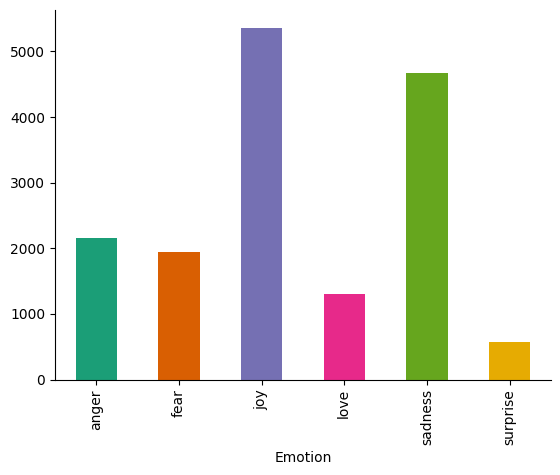

In [103]:
emotions = df_train['Emotion'].unique().tolist()

df_train.groupby('Emotion').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [104]:
emotions

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

### Pipeline

In [105]:
nltk.download('wordnet')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
lemmatizer = WordNetLemmatizer()

#text is already lowercased and clean, so i skip those steps
def preprocess_text(text):
    tokens_dict = tokenizer(text)
    tokens = tokens_dict['input_ids']
    tokens = [str(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df_train['Text1'] = df_train['Text'].apply(preprocess_text)
df_test['Text1'] = df_test['Text'].apply(preprocess_text)
df_val['Text1'] = df_val['Text'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [106]:
df_train

,Text,Emotion,Text1
0,i didnt feel humiliated,sadness,101 1045 2134 2102 2514 26608 102
1,i can go from feeling so hopeless to so damned...,sadness,101 1045 2064 2175 2013 3110 2061 20625 2000 2...
2,im grabbing a minute to post i feel greedy wrong,anger,101 10047 9775 1037 3371 2000 2695 1045 2514 2...
3,i am ever feeling nostalgic about the fireplac...,love,101 1045 2572 2412 3110 16839 9080 12863 2055 ...
4,i am feeling grouchy,anger,101 1045 2572 3110 24665 7140 11714 102
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101 1045 2074 2018 1037 2200 4766 2051 1999 19...
15996,i am now turning and i feel pathetic that i am...,sadness,101 1045 2572 2085 3810 1998 1045 2514 17203 2...
15997,i feel strong and good overall,joy,101 1045 2514 2844 1998 2204 3452 102
15998,i feel like this was such a rude comment and i...,anger,101 1045 2514 2066 2023 2001 2107 1037 12726 7...


In [107]:
x_train, y_train = df_train['Text1'], df_train['Emotion']
x_test, y_test = df_test['Text1'], df_test['Emotion']
x_val, y_val = df_val['Text1'], df_val['Emotion']

In [108]:
label_encoder = LabelEncoder()
label_encoder.fit(emotions)

y_train = tf.keras.utils.to_categorical(label_encoder.transform(y_train), num_classes=len(emotions))
y_test = tf.keras.utils.to_categorical(label_encoder.transform(y_test), num_classes=len(emotions))
y_val = tf.keras.utils.to_categorical(label_encoder.transform(y_val), num_classes=len(emotions))

### Функція для виведення графіків

In [142]:
def plot_learning_curve(history, figsize=(10, 5)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].plot(history.history['accuracy'], color='#b8113d')
    axs[0].plot(history.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(history.history['loss'], color='#b8113d')
    axs[1].plot(history.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [110]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=emotions, yticklabels=emotions)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

In [111]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 3, min_lr=0.000001)]

## 1. Модель №1

In [112]:
vector = layers.TextVectorization(max_tokens=10000, output_mode='tf_idf')
vector.adapt(tf.data.Dataset.from_tensor_slices(x_train).batch(32))

In [113]:
model1 = models.Sequential([
    vector,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(emotions), activation='softmax')
])

model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=['accuracy']
)

In [116]:
start_time1 = time.time()

hist1 = model1.fit(
    x = x_train,
    y = y_train,
    epochs = 60,
    batch_size = 128,
    callbacks = callback, #Early stopping ON
    validation_data = (x_val, y_val)
)

end_time1 = time.time()

Epoch 1/60
125/125 [==============================] - 1s 9ms/step - loss: 1.4915 - accuracy: 0.5309 - val_loss: 1.5135 - val_accuracy: 0.5185 - lr: 3.0000e-05
Epoch 2/60
125/125 [==============================] - 1s 8ms/step - loss: 1.3913 - accuracy: 0.5817 - val_loss: 1.4319 - val_accuracy: 0.5660 - lr: 3.0000e-05
Epoch 3/60
125/125 [==============================] - 2s 13ms/step - loss: 1.2717 - accuracy: 0.6389 - val_loss: 1.3325 - val_accuracy: 0.6085 - lr: 3.0000e-05
Epoch 4/60
125/125 [==============================] - 1s 11ms/step - loss: 1.1374 - accuracy: 0.7151 - val_loss: 1.2230 - val_accuracy: 0.6705 - lr: 3.0000e-05
Epoch 5/60
125/125 [==============================] - 1s 9ms/step - loss: 1.0015 - accuracy: 0.8043 - val_loss: 1.1154 - val_accuracy: 0.7305 - lr: 3.0000e-05
Epoch 6/60
125/125 [==============================] - 1s 9ms/step - loss: 0.8796 - accuracy: 0.8653 - val_loss: 1.0241 - val_accuracy: 0.7760 - lr: 3.0000e-05
Epoch 7/60
125/125 [========================

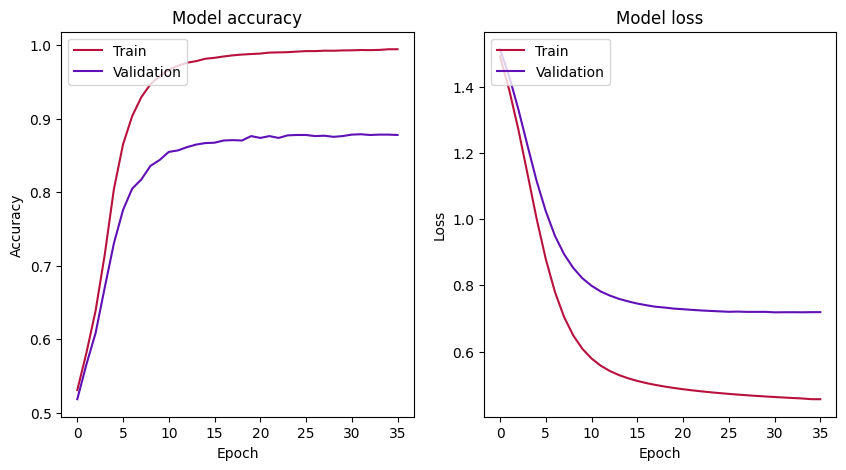

In [117]:
plot_learning_curve(hist1)

63/63 [==============================] - 1s 6ms/step


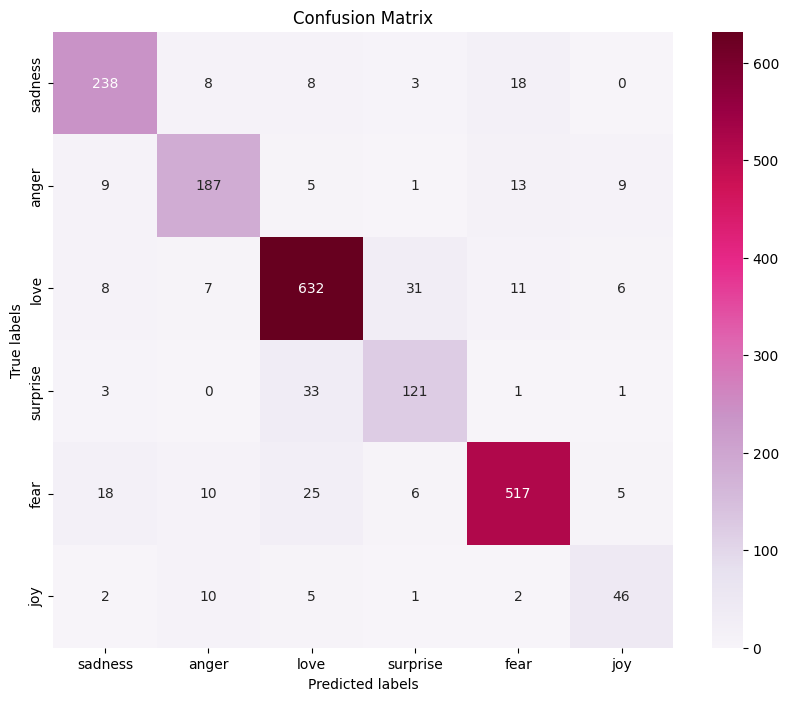

In [118]:
y_pred1 = model1.predict(x_test)
y_pred1_uint8 = np.argmax(y_pred1, axis=1).astype(np.uint8)
y_test1_unit8 = np.argmax(y_test, axis=1).astype(np.uint8)

plot_confusion_matrix(y_test1_unit8, y_pred1_uint8)

In [119]:
print("Classification Report:")
print(classification_report(y_test1_unit8, y_pred1_uint8))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       275
           1       0.84      0.83      0.84       224
           2       0.89      0.91      0.90       695
           3       0.74      0.76      0.75       159
           4       0.92      0.89      0.90       581
           5       0.69      0.70      0.69        66

    accuracy                           0.87      2000
   macro avg       0.82      0.83      0.82      2000
weighted avg       0.87      0.87      0.87      2000



## 2. Модель №2

In [120]:
vector2 = layers.TextVectorization(max_tokens=10000)
vector2.adapt(tf.data.Dataset.from_tensor_slices(x_train).batch(32))

In [121]:
model2 = models.Sequential([
    vector2,
    layers.Embedding(10000, 32),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(emotions), activation='softmax')
])

model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=['accuracy']
)

In [122]:
start_time2 = time.time()

hist2 = model2.fit(
    x = x_train,
    y = y_train,
    epochs = 60,
    batch_size = 128,
    callbacks = callback,  # Early stopping ON
    validation_data = (x_val, y_val)
)

end_time2 = time.time()

Epoch 1/60
125/125 [==============================] - 10s 69ms/step - loss: 1.7247 - accuracy: 0.2849 - val_loss: 1.6323 - val_accuracy: 0.2835 - lr: 3.0000e-04
Epoch 2/60
125/125 [==============================] - 5s 37ms/step - loss: 1.6180 - accuracy: 0.3385 - val_loss: 1.6174 - val_accuracy: 0.3520 - lr: 3.0000e-04
Epoch 3/60
125/125 [==============================] - 6s 48ms/step - loss: 1.6099 - accuracy: 0.3351 - val_loss: 1.6117 - val_accuracy: 0.3520 - lr: 3.0000e-04
Epoch 4/60
125/125 [==============================] - 4s 26ms/step - loss: 1.5985 - accuracy: 0.3544 - val_loss: 1.5957 - val_accuracy: 0.3935 - lr: 3.0000e-04
Epoch 5/60
125/125 [==============================] - 3s 27ms/step - loss: 1.5647 - accuracy: 0.4806 - val_loss: 1.5459 - val_accuracy: 0.4900 - lr: 3.0000e-04
Epoch 6/60
125/125 [==============================] - 3s 21ms/step - loss: 1.4680 - accuracy: 0.5452 - val_loss: 1.4251 - val_accuracy: 0.5560 - lr: 3.0000e-04
Epoch 7/60
125/125 [===================

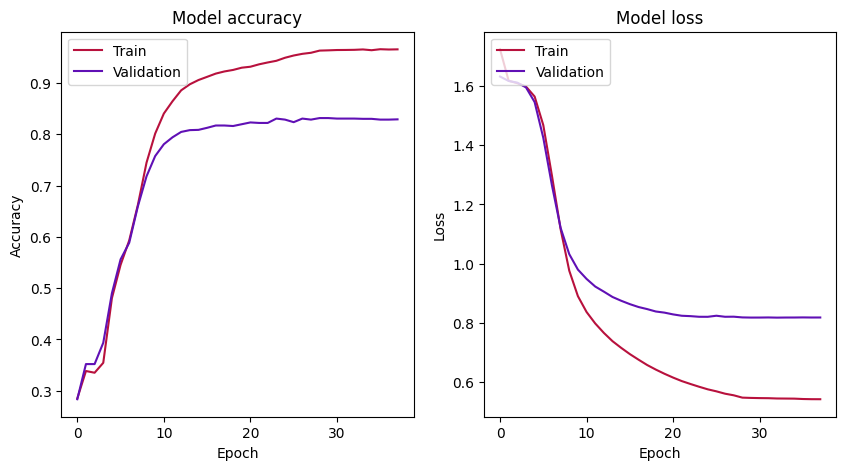

In [123]:
plot_learning_curve(hist2)

63/63 [==============================] - 0s 4ms/step


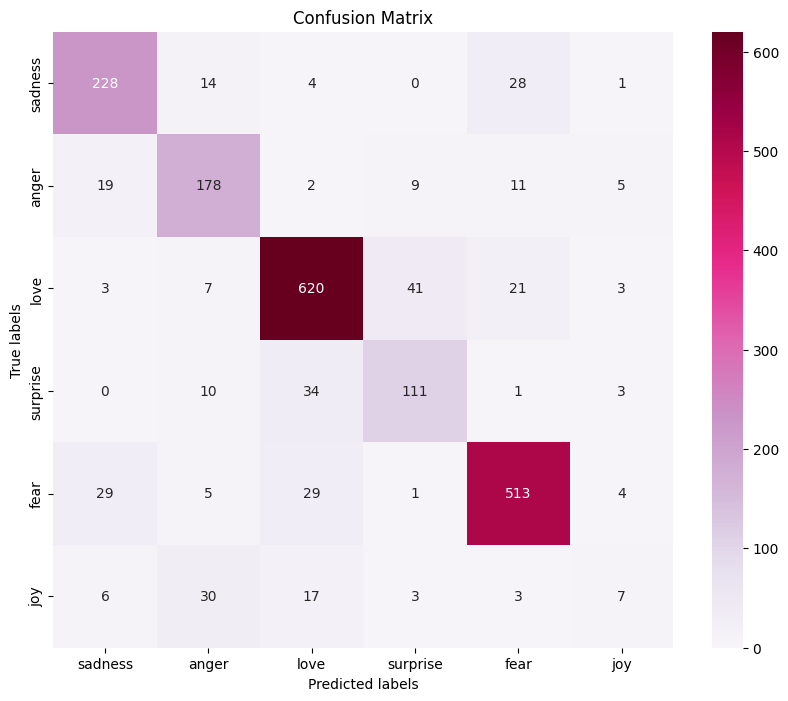

In [124]:
y_pred2 = model2.predict(x_test)
y_pred2_uint8 = np.argmax(y_pred2, axis=1).astype(np.uint8)
y_test2_unit8 = np.argmax(y_test, axis=1).astype(np.uint8)

plot_confusion_matrix(y_test2_unit8, y_pred2_uint8)

In [125]:
print("Classification Report:")
print(classification_report(y_test2_unit8, y_pred2_uint8))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       275
           1       0.73      0.79      0.76       224
           2       0.88      0.89      0.89       695
           3       0.67      0.70      0.69       159
           4       0.89      0.88      0.89       581
           5       0.30      0.11      0.16        66

    accuracy                           0.83      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.82      0.83      0.82      2000



## 3. Модель №3

In [126]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = layers.Dropout(rate)
        self.lnorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.ff = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
            ])
        self.dropout2 = layers.Dropout(rate)
        self.lnorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
      attn = self.att(inputs, inputs)
      attn = self.dropout1(attn)
      norm = self.lnorm1(inputs + attn)
      ffn = self.ff(norm)
      ffn = self.dropout2(ffn)
      return self.lnorm2(norm + ffn)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [127]:
embed_dim = 32
num_heads = 2
ff_dim = 32

inputs = layers.Input(shape=(200,))
emb_layer = TokenAndPositionEmbedding(200, 20000, embed_dim)
x = emb_layer(inputs)
encoder = TransformerBlock(embed_dim, num_heads, ff_dim)
x = encoder(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(len(emotions), activation="softmax")(x)

model3 = keras.Model(inputs=inputs, outputs=outputs)

In [128]:
model3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=['accuracy']
)

In [129]:
max_length = 200

x_train_ = tokenizer(
    df_train["Text"].tolist(),
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors="tf"
)["input_ids"]
x_test_ = tokenizer(
    df_test["Text"].tolist(),
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors="tf"
)["input_ids"]
x_val_ = tokenizer(
    df_val["Text"].tolist(),
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors="tf"
)["input_ids"]

In [130]:
start_time3 = time.time()

hist3 = model3.fit(
    x = x_train_,
    y = y_train,
    epochs = 60,
    batch_size = 128,
    callbacks = callback,  # Early stopping ON
    validation_data = (x_val_, y_val)
)

end_time3 = time.time()

Epoch 1/60
125/125 [==============================] - 26s 161ms/step - loss: 1.6201 - accuracy: 0.3332 - val_loss: 1.6238 - val_accuracy: 0.3520 - lr: 3.0000e-04
Epoch 2/60
125/125 [==============================] - 14s 113ms/step - loss: 1.6092 - accuracy: 0.3465 - val_loss: 1.6092 - val_accuracy: 0.3520 - lr: 3.0000e-04
Epoch 3/60
125/125 [==============================] - 9s 70ms/step - loss: 1.5986 - accuracy: 0.3553 - val_loss: 1.6021 - val_accuracy: 0.4135 - lr: 3.0000e-04
Epoch 4/60
125/125 [==============================] - 6s 50ms/step - loss: 1.5820 - accuracy: 0.3941 - val_loss: 1.5935 - val_accuracy: 0.3925 - lr: 3.0000e-04
Epoch 5/60
125/125 [==============================] - 4s 32ms/step - loss: 1.5185 - accuracy: 0.4384 - val_loss: 1.3883 - val_accuracy: 0.5415 - lr: 3.0000e-04
Epoch 6/60
125/125 [==============================] - 3s 23ms/step - loss: 1.0421 - accuracy: 0.7038 - val_loss: 0.9601 - val_accuracy: 0.7595 - lr: 3.0000e-04
Epoch 7/60
125/125 [================

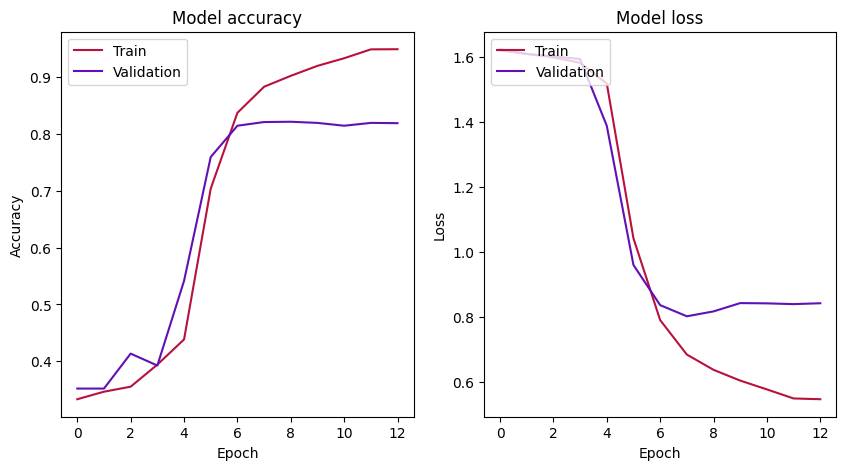

In [131]:
plot_learning_curve(hist3)

63/63 [==============================] - 1s 6ms/step


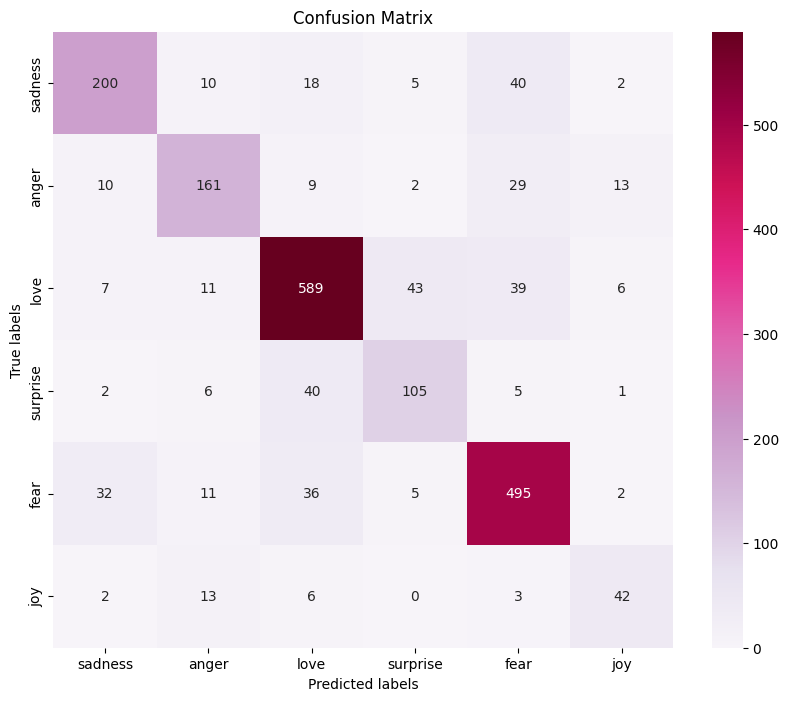

In [132]:
y_pred3 = model3.predict(x_test_)
y_pred3_uint8 = np.argmax(y_pred3, axis=1).astype(np.uint8)
y_test3_unit8 = np.argmax(y_test, axis=1).astype(np.uint8)

plot_confusion_matrix(y_test3_unit8, y_pred3_uint8)

In [133]:
print("Classification Report:")
print(classification_report(y_test3_unit8, y_pred3_uint8))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       275
           1       0.76      0.72      0.74       224
           2       0.84      0.85      0.85       695
           3       0.66      0.66      0.66       159
           4       0.81      0.85      0.83       581
           5       0.64      0.64      0.64        66

    accuracy                           0.80      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.80      0.80      0.80      2000



# Порівняння результатів

### Training time

In [149]:
train_time1 = start_time1 - end_time1
train_time2 = start_time2 - end_time2
train_time3 = start_time3 - end_time3

print("Training time of model 1: {:.2f} seconds".format(-train_time1))
print("Training time of model 2: {:.2f} seconds".format(-train_time2))
print("Training time of model 3: {:.2f} seconds".format(-train_time3))

Training time of model 1: 39.24 seconds
Training time of model 2: 79.05 seconds
Training time of model 3: 86.07 seconds


In [151]:
y_pred1_labels = np.argmax(y_pred1, axis=1)
y_pred2_labels = np.argmax(y_pred2, axis=1)
y_pred3_labels = np.argmax(y_pred3, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

f1_score1 = f1_score(y_test_labels, y_pred1_labels, average='micro')
f1_score2 = f1_score(y_test_labels, y_pred2_labels, average='micro')
f1_score3 = f1_score(y_test_labels, y_pred3_labels, average='micro')

print("F1 Score for model 1:", f1_score1)
print("F1 Score for model 2:", f1_score2)
print("F1 Score for model 3:", f1_score3)

F1 Score for model 1: 0.8705
F1 Score for model 2: 0.8285
F1 Score for model 3: 0.796


### Learning curves

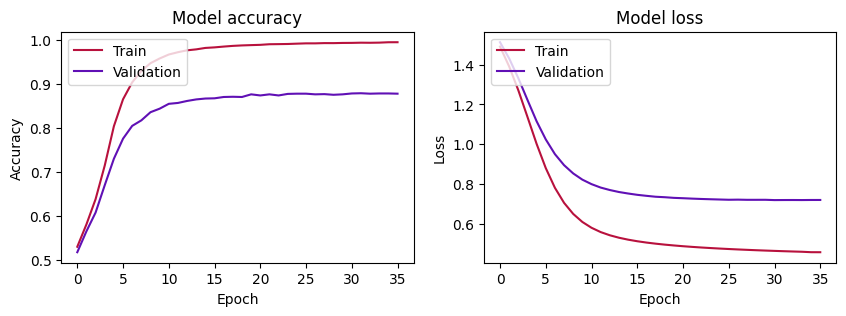

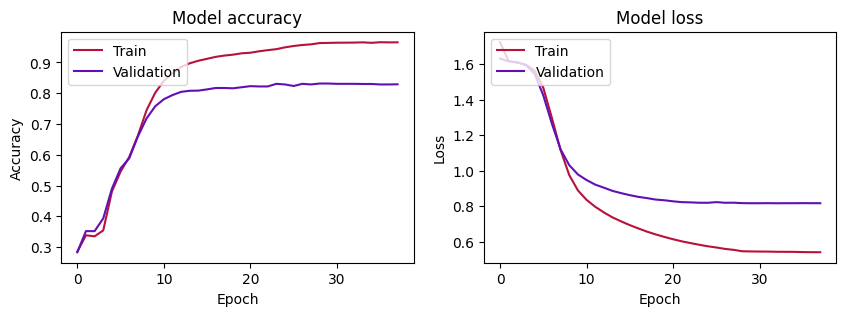

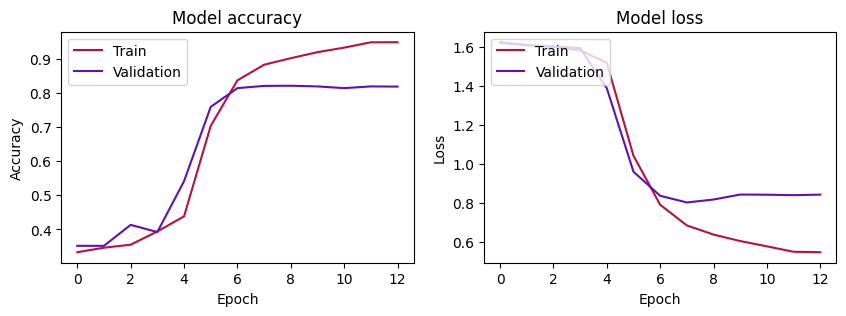

In [145]:
plot_learning_curve(hist1, figsize=(10,3))
plot_learning_curve(hist2, figsize=(10,3))
plot_learning_curve(hist3, figsize=(10,3))

# Висновки

Час тренування моделей збільшувався з кожною моделлю, попри те, що кількість епох, необхідна щоб натренувати модель, зменшувалася. Перша, найпростіша, модель показала найкращі результати серед усіх 3-х моделей, скоріш за все тому що дані були доволі прості.